## 데이터 탐색_v2
이번 데이터 탐색의 목적은 **Melon Playlist Continuation**에 참여하는 사람들이 데이터 및 대회에 대한 이해를 도와주기 위함입니다. 분석을 통해서 각각의 데이터는 어떻게 구성되어있는지 특성을 파악하고 어떤식으로 접근해야 할 지에 대한 아이디어를 탐색해보겠습니다. 

기본적인 내용은 [Melon Playlist Continuation 대회 데이터 전처리 & EDA
](https://arena.kakao.com/forum/topics/191)의 글을 토대로 작성하였습니다. 

In [7]:
import numpy as np
import pandas as pd
import scipy  
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import notebook
import json
from collections import Counter
from plotnine import *
import plotnine

In [8]:
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

font_path = '/Users/1000999/Downloads/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')

## 멜론 DJ 플레이리스트
이번에 Melon Playlist Continuation으로 제공된 데이터는 단순 플레이리스트가 아닌 DJ 플레이리스트입니다. 이러한 플레이리스트는 **멜론을 사용하는 유저가 직접 플레이리스트를 만들어서 다른 사람들에게 공개한 리스트**으로 정의할 수 있습니다. 단, 이는 아무나 할 수 없고, 멜론 활동 이력과 플레이리스트를 심사한 후에 가입할 수 있습니다. 그렇기에 어떤 식으로 심사하는지를 이해한다면 어울리는 곡들을 맞추는데 더 용이할 수 있습니다. 

![](https://drive.google.com/uc?export=view&id=1zfGTJT3rFJuTrBnIuX-WTwV6msQXjtGi)

실제 멜론 사이트(https://www.melon.com/dj/today/djtoday_list.htm)에 들어가보면 멜론에서는 어떤식으로 데이터가 구성되어있는지 알 수 있습니다. 한번 DJ 신청하기를 통해서 어떤 식으로 심사하는지 확인해보겠습니다. 

멜론 DJ플레이리스트를 신청하려면 첫번째로 다음의 항목을 만족해야 합니다. 

![](https://drive.google.com/uc?export=view&id=1B1r83nX2AlWOn3nkGyobQab_3eqIdA4t)

- 곡과 태그는 최소 10개, 2개 이상이어야하고 제목은 반드시 있어야합니다. 그렇기에 val과 test에서 제목이 없는경우와 곡과 태그가 최소수를 만족하지 못하는 경우는 아레나측에서 임의로 지운 것으로 판단할 수 있습니다.
- **가수/앨범/곡의 고른 분배 및 배치** 라는 항목이 있습니다. 문장만 봐서는 동일한 가수와 동일한 앨범의 곡이 많이 들어가면 안된다는데 실제로 데이터가 그런지는 아래에서 확인해보겠습니다. 
- **선곡의 테마 및 장르**를 표현할 수 있어야 합니다. DJ를 신청할 때는 반드시 아래의 테마 혹은 장르를 선택해야합니다. 그렇기에 플레이리스트가 어떤 테마 혹은 장르를 가지는 지 알 수 있다면, 모델의 성능을 더 좋아질 것으로 판단됩니다. 

<img src="https://drive.google.com/uc?export=view&id=1SsXxbfk9UFVsxta2qW_58WjKgJa-HYLG"  onerror="this.style.display='none'" /><br><br>

## 목표 및 평가함수
- 목표: 주어진 플레이리스트의 정보를 참조하여 해당 플레이리스트에 원래 수록되어 있었을 곡 리스트와 태그 리스트를 예측하는 것이 이 대회의 목표입니다. 각 플레이리스트별로 원래 플레이리스트에 들어있었을 것이라 예상되는 곡 100개, 태그 10개를 제출해 주세요.

- 평가함수: NDCG 

![](https://drive.google.com/uc?export=view&id=1VFaBFwSECpoSlGUh_cqnjaJdCheR2rtN)

- 제출 포맷 
```
[
    {
        'id': 플레이리스트 id,
        'songs': 예측한 곡 100개 리스트,
        'tags': 예측한 태그 10개 리스트
    },
    ... (n개)
]
```

## 데이터의 분포 및 구성
위에서 나온 정보를 보기에 앞서서 데이터가 어떤식으로 구성되었는지 확인해보겠습니다. 일단, 데이터의 스키마는 아래와 같습니다. 
![](https://drive.google.com/uc?export=view&id=1Q8SZx_v1MWbq1NXB-Xy1zjAb7DDbypH8)

In [10]:
%%time 
# 입력데이터 로드 
train = pd.read_json('train.json', typ = 'frame')
test = pd.read_json('test.json', typ = 'frame')
val = pd.read_json('val.json', typ = 'frame')
genre = pd.read_json('genre_gn_all.json', typ = 'series')
meta = pd.read_json('song_meta.json', typ = 'frame')

CPU times: user 13.8 s, sys: 1.35 s, total: 15.2 s
Wall time: 15.4 s


## train/test에 대한 이해

In [11]:
train.head(2)

ImportError: cannot import name 'is_url' from 'pandas.io.common' (/usr/local/lib/python3.7/site-packages/pandas/io/common.py)

      id  like_cnt plylst_title  \
0  61281        71      여행같은 음악   
1  10532         1      요즘 너 말야   

                                               songs      tags  \
0  [525514, 129701, 383374, 562083, 297861, 13954...       [락]   
1  [432406, 675945, 497066, 120377, 389529, 24427...  [추억, 회상]   

                 updt_date  
0  2013-12-19 18:36:19.000  
1  2014-12-02 16:19:42.000  

In [12]:
train.shape

(115071, 6)

컬럼의 의미 
- tags : 플레이리스트에 달려있는 태그 목록 
- id : 플레이리스트 아이디
- plylst_title : 플레이리스 제목 
- songs : 플레이리스트에 수록된 곡 
- like_cnt : 플레이리스트 좋아요 수 
- updt_date : 플레이리스트가 최종 수정된 시각 

In [14]:
train[train['like_cnt'] == train.like_cnt.max()]

ImportError: cannot import name 'is_url' from 'pandas.io.common' (/usr/local/lib/python3.7/site-packages/pandas/io/common.py)

          id  like_cnt                            plylst_title  \
46524  74220     53211  HOT TRENDY POP: 놓쳐선 안될 'POP' (매주 업데이트)   

                                                   songs  \
46524  [159317, 368264, 600999, 274905, 643023, 24070...   

                                               tags                updt_date  
46524  [노동요, 취향저격, 드라이브, Pop, 기분전환, 트렌디, 스트레스, 신나는]  2020-04-17 14:32:23.000  

In [15]:
def mapping_function(data, col1, col2): 
    # 플레이리스트 아이디(col1)와 수록곡(col2) 추출
    plylst_song_map = data[[col1, col2]]

    # unnest col2
    plylst_song_map_unnest = np.dstack(
        (
            np.repeat(plylst_song_map[col1].values, list(map(len, plylst_song_map[col2]))), 
            np.concatenate(plylst_song_map[col2].values)
        )
    )

    # unnested 데이터프레임 생성 : plylst_song_map
    plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
    plylst_song_map[col1] = plylst_song_map[col1].astype(str)
    plylst_song_map[col2] = plylst_song_map[col2].astype(str)

    # unnest 객체 제거
    del plylst_song_map_unnest
    return plylst_song_map

In [16]:
playlst_song_map = mapping_function(train, 'id', 'songs')
agg = pd.DataFrame(playlst_song_map['songs'].value_counts()).reset_index()
agg.columns = ['곡', '플레이리스트내의 등장횟수']
meta['id'] = meta['id'].astype(str)
agg = agg.merge(meta[['id', 'artist_name_basket', 'song_name', 'song_gn_gnr_basket']], how='left', left_on='곡', right_on='id')

In [17]:
song_count_df = agg.groupby(['플레이리스트내의 등장횟수'])['플레이리스트내의 등장횟수'].agg({'count'}).reset_index().rename(columns={'count':'노래의 개수'})
song_count_df100 = song_count_df[song_count_df['플레이리스트내의 등장횟수'] <= 100]

(ggplot(data=song_count_df100) 
    + geom_bar(aes(x='플레이리스트내의 등장횟수', y='노래의 개수', group='플레이리스트내의 등장횟수', fill='플레이리스트내의 등장횟수'), color='black', stat='identity')
    + scale_color_hue(l=0.45)
    + theme_light() 
    + labs(title = '플레이리스트내의 등장횟수에 따른 노래의 개수',
         x = '플레이리스트내의 등장횟수',
         y = '노래의 개수')
    + theme(text = element_text(fontproperties=font_name),
        #axis_text_x = element_text(angle=80),
        figure_size=(12,8),
        legend_position="none"))

OptionError: "No such keys(s): 'compute.use_numexpr'"

In [10]:
print("플레이리스트내 1번 등장한 노래의 수:", agg[agg['플레이리스트내의 등장횟수'] == 1].shape[0])
print("플레이리스트내 2번 이상 등장한 노래의 수:", agg[agg['플레이리스트내의 등장횟수'] > 1].shape[0])

플레이리스트내 1번 등장한 노래의 수: 299028
플레이리스트내 2번 이상 등장한 노래의 수: 316114


In [11]:
round(pd.DataFrame(agg['플레이리스트내의 등장횟수'].describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']]).T, 2)

,min,25%,50%,mean,75%,max,std
플레이리스트내의 등장횟수,1.0,1.0,2.0,8.59,4.0,2175.0,39.48


평균적으로 노래당 8.59개의 플레이리스트내에 수록이 되고 50%의 노래가 2개의 플레이리스트내에 수록되는 것을 알 수 있습니다. 가장 인기가 있는 노래는 아래와 같습니다. 

In [12]:
agg.loc[0:4][['artist_name_basket', 'song_name']]

,artist_name_basket,song_name
0,[아이유],밤편지
1,[정준일],안아줘
2,[폴킴],비
3,[가을방학],가끔 미치도록 네가 안고 싶어질 때가 있어
4,[박효신],눈의 꽃


In [13]:
playlst_genre_map = mapping_function(agg, 'id', 'song_gn_gnr_basket')
playlst_1 = playlst_genre_map[playlst_genre_map['id'].isin(agg[agg['플레이리스트내의 등장횟수'] == 1]['id'].values)].rename(columns={'song_gn_gnr_basket':'gnr_code'})
playlst_2 = playlst_genre_map[playlst_genre_map['id'].isin(agg[agg['플레이리스트내의 등장횟수'] > 1]['id'].values)].rename(columns={'song_gn_gnr_basket':'gnr_code'})

genre_gn_all = pd.DataFrame(genre, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})
playlst_1 = playlst_1.merge(genre_gn_all, how='left', on='gnr_code')
playlst_2 = playlst_2.merge(genre_gn_all, how='left', on='gnr_code')

플레이리스트내 1번 등장한 노래의 장르 

In [14]:
playlst_1.groupby(['gnr_name'])['gnr_name'].agg({'count'}).reset_index().sort_values(by='count', ascending=False).head(10)

,gnr_name,count
10,록/메탈,39414
22,클래식,32841
4,POP,30987
19,일렉트로니카,28017
20,재즈,23158
9,랩/힙합,22766
7,뉴에이지,19370
3,OST,16855
5,R&B/Soul,16261
13,발라드,14575


플레이리스트내 2번 이상 등장한 노래의 장르 

In [15]:
playlst_2.groupby(['gnr_name'])['gnr_name'].agg({'count'}).reset_index().sort_values(by='count', ascending=False).head(10)

,gnr_name,count
10,록/메탈,41515
13,발라드,37986
4,POP,37101
9,랩/힙합,33802
19,일렉트로니카,29926
5,R&B/Soul,26431
18,인디음악,26296
3,OST,22131
20,재즈,18350
7,뉴에이지,17047


In [17]:
playlst_tag_map = mapping_function(train, 'id', 'tags')
agg = pd.DataFrame(playlst_tag_map['tags'].value_counts()).reset_index()
agg.columns = ['태그', '플레이리스트내의 등장횟수']

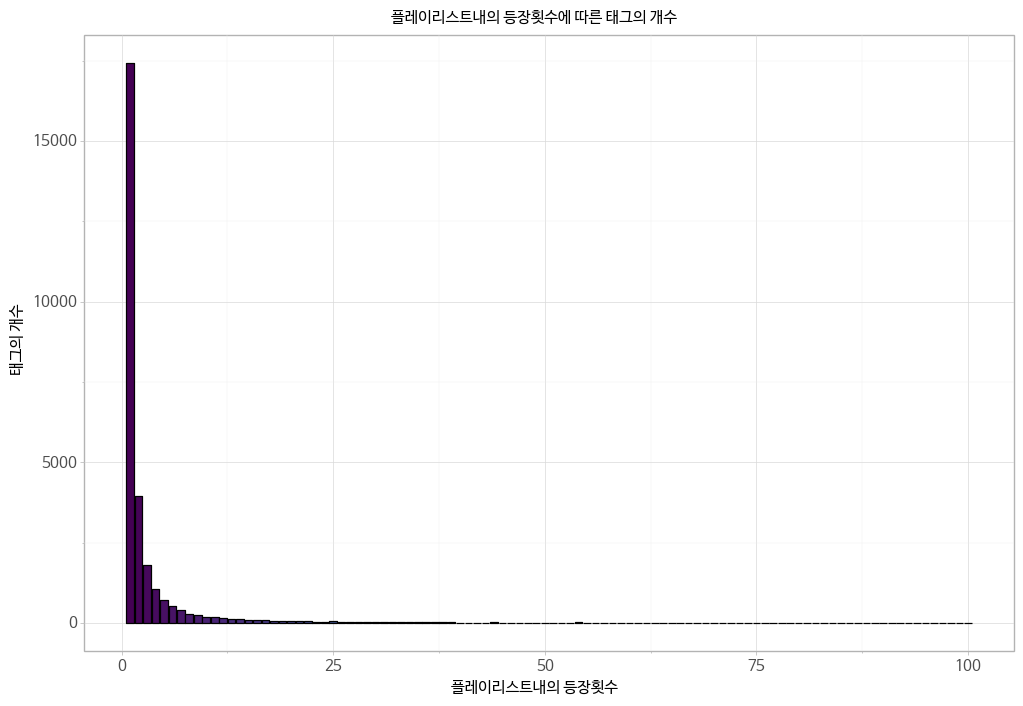

<ggplot: (126938126484)>

In [18]:
tag_count_df = agg.groupby(['플레이리스트내의 등장횟수'])['플레이리스트내의 등장횟수'].agg({'count'}).reset_index().rename(columns={'count':'태그의 개수'})
tag_count_df100 = tag_count_df[tag_count_df['플레이리스트내의 등장횟수'] <= 100]

(ggplot(data=tag_count_df100) 
    + geom_bar(aes(x='플레이리스트내의 등장횟수', y='태그의 개수', group='플레이리스트내의 등장횟수', fill='플레이리스트내의 등장횟수'), color='black', stat='identity')
    + scale_color_hue(l=0.45)
    + theme_light() 
    + labs(title = '플레이리스트내의 등장횟수에 따른 태그의 개수',
         x = '플레이리스트내의 등장횟수',
         y = '태그의 개수')
    + theme(text = element_text(fontproperties=font_name),
        #axis_text_x = element_text(angle=80),
        figure_size=(12,8),
        legend_position="none"))

In [19]:
print("플레이리스트내 1번 등장한 태그의 수:", agg[agg['플레이리스트내의 등장횟수'] == 1].shape[0])
print("플레이리스트내 2번 이상 등장한 태그의 수:", agg[agg['플레이리스트내의 등장횟수'] > 1].shape[0])

플레이리스트내 1번 등장한 태그의 수: 17431
플레이리스트내 2번 이상 등장한 태그의 수: 11729


In [20]:
round(pd.DataFrame(agg['플레이리스트내의 등장횟수'].describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']]).T, 2)

,min,25%,50%,mean,75%,max,std
플레이리스트내의 등장횟수,1.0,1.0,1.0,16.34,3.0,16465.0,247.01


노래와 태그의 플레이리스트내 등장 횟수는 비슷한 양상을 보입니다. 하지만, 노래보다는 태그의 경우가 1번 나온 경우가 많습니다. 그리고 평균도 노래가 8.59인 반면에 태그는 16.34으로 약 2배에 가깝습니다. 편차는 39.48에 비해 247.01으로 6배 가까이 높습니다. 이를 보아서, 태그의 경우 노래보다 등장하는 값들만 등장하는 것을 파악할 수 있습니다. 

In [28]:
agg.sort_values(by='플레이리스트내의 등장횟수', ascending=False)[0:10]['태그'].values

array(['기분전환', '감성', '휴식', '발라드', '잔잔한', '드라이브', '힐링', '사랑', '새벽', '밤'],
      dtype=object)

In [25]:
agg[agg['플레이리스트내의 등장횟수'] == 1]['태그'].values

array(['일본매장', '방탄의성장기', '카페로', ..., '신곡스밍', '처음에는', ''], dtype=object)

실제 자주 등장하는 태그와 그렇지 않은 태그를 비교해보면 자주 등장하는 태그들이 좀 더 명확한 것을 볼 수 있습니다. 그리고 재밌는 것은 위의 태그들중에 아래의 테마/장르에 속하는 태그들이 있다는 점입니다. 

<img src="https://drive.google.com/uc?export=view&id=1T271qtD4JjiugH9BPioThJnHcttvty_d"  onerror="this.style.display='none'" /><br><br>

이러한 특성을 잘 이용한다면, 곡들로 특정 태그를 유추하고 특정 태그들로 장르/테마를 유추하는 것 또한 가능해보입니다. 

## genre에 대한 이해
[Melon Playlist Continuation 대회 데이터 전처리 & EDA](https://arena.kakao.com/forum/topics/191)에 따르면 장르 코드는 총 254개의 장르코드가 존재하며 30개의 대분류 장르코드와 224개의 상세 장르코드로 분류할 수 있습니다. 그리고 대분류와 상세의 분류는 끝자리 2자리수가 00인지, 아닌지로 구분합니다. 

In [33]:
genre_gn_all = pd.DataFrame(genre, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']

dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00'].reset_index(drop=True)
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

print("대분류 코드의 수:", gnr_code.shape[0])
print("상세분류 코드의 수:", dtl_gnr_code.shape[0])

대분류 코드의 수: 30
상세분류 코드의 수: 224


In [34]:
# 앞자리 네 자리 공통코드 추출
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]
gnr_code_tree

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN01,GN0101,세부장르전체
1,GN0100,발라드,GN01,GN0102,'80
2,GN0100,발라드,GN01,GN0103,'90
3,GN0100,발라드,GN01,GN0104,'00
4,GN0100,발라드,GN01,GN0105,'10-
...,...,...,...,...,...
220,GN2800,뮤직테라피,GN28,GN2806,반려동물
221,GN2900,뮤지컬,GN29,GN2901,세부장르전체
222,GN2900,뮤지컬,GN29,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN29,GN2903,국외뮤지컬


In [35]:
gnr_code_tree['dtl_gnr_name'].value_counts()

세부장르전체       27
'00          10
'10-         10
'90           7
'80           6
             ..
R&B           1
성인가요'00-      1
컨템포러리 R&B     1
힙합            1
실내악           1
Name: dtl_gnr_name, Length: 146, dtype: int64

In [38]:
gnr_code_tree[gnr_code_tree['dtl_gnr_name'] == "'00"]['gnr_name'].values

array(['발라드', '댄스', '인디음악', '록/메탈', '포크/블루스', 'POP', '록/메탈', '일렉트로니카',
       '랩/힙합', 'R&B/Soul'], dtype=object)

대분류 코드의 경우는 세부장르전체로 똑같은 이름을 가집니다. 특이한 점 중 하나는 여러번 등장한는 세부장르명이 있습니다. 예를들어, '00의 경우 위의 10개의 장르에서 공통적으로 등장하는 것을 볼 수 있습니다. 

## mel에 대한 이해

In [39]:
mel = np.load("./arena_mel/702/702000.npy")
mel.shape

(48, 1876)

In [44]:
import librosa
import librosa.display

[Mel-Spectrogram 문의](https://arena.kakao.com/forum/topics/214)에 언급된 파라미터(numbands=48, sampleRate=16000, frameSize=512, hopSize=256, window='hann', weighting='linear', warpingFormula='slaneyMel', normalize='unit_tri'
)를 이용해서 Mel-Spectrogram을 보면 아래와 같습니다. 

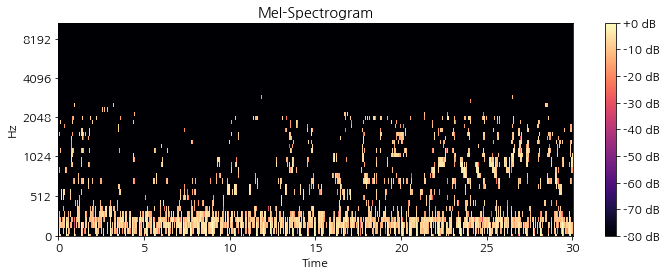

In [48]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), y_axis='mel', sr=16000, hop_length=256, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.savefig('Mel-Spectrogram example.png')
plt.show()

- 48개의 mel filter에 1876개의 프레임 
- frameSize(windowSize, FFT points) 512로 hopSize 256간격만큼 stride(hop)를 진행 

In [61]:
print("시간 :" , 1876 * np.ceil(16000/512) / 2 / 1000)

시간 : 30.016


약, 30초 정도의 곡에 Hz가 위의 그림처럼 담겨져있습니다.

## meta에 대한 이해

In [50]:
meta.head()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4


In [51]:
meta.shape

(707989, 9)

컬럼의 의미

- song_gn_dtl_gnr_basket :  곡의 세부장르
- issue_date : 발매일
- album_name : 앨범 제목
- album_id : 앨범 아이디
- artist_id_basket : 아티스트 아이디
- song_name : 곡 제목
- song_gn_gnr_basket : 곡의 장르
- artist_name_basket : 아티스트명 
- id : 곡의 아이디

## like_cnt, updt_year에 따른 데이터의 분포

한가지 특이한 점은 데이터의 분포입니다. 아래의 like_cnt와 updt_year에 의한 데이터의 분포를 살펴보면, train/val/test가 매우 유사한 것을 알 수 있고 위의 두가지 값을 통해서 데이터가 샘플링되었다고 추측할 수 있습니다. 

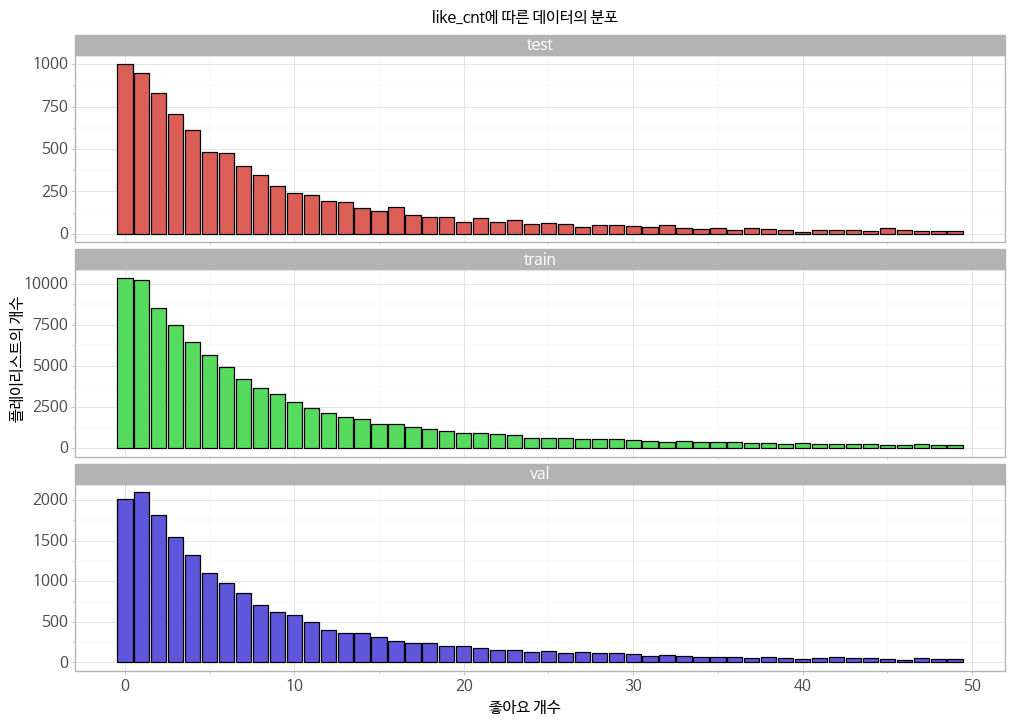

<ggplot: (-9223371915585557735)>

In [43]:
train['type'] = 'train'; val['type'] = 'val'; test['type'] = 'test'
total = pd.concat([train, val], axis=0)
total = pd.concat([total, test], axis=0)
agg = total.groupby(['type', 'like_cnt'])['like_cnt'].agg({'count'}).reset_index().rename(columns = {'count': 'like_cnt의 수'})
agg = agg[agg['like_cnt'] < 50]

(ggplot(data=agg) 
    + geom_bar(aes(x='like_cnt', y='like_cnt의 수', group='type', fill='type'), color='black', stat='identity')
    + facet_wrap('type', nrow=3, scales = "free_y")
    #+ scale_x_discrete(limits=sorted_columns)
    + scale_color_hue(l=0.45)
    + theme_light() 
    + labs(title = 'like_cnt에 따른 데이터의 분포',
         x = '좋아요 개수',
         y = '플레이리스트의 개수')
    + theme(text = element_text(fontproperties=font_name),
        #axis_text_x = element_text(angle=80),
        figure_size=(12,8),
        legend_position="none"))

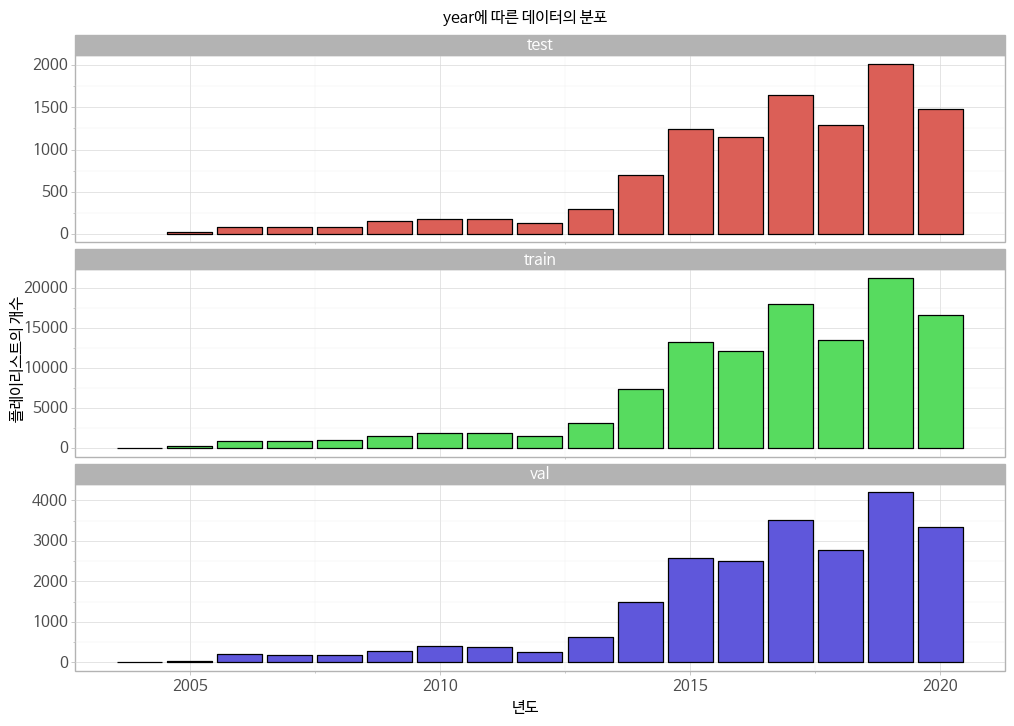

<ggplot: (-9223371915585164137)>

In [44]:
total['year'] = pd.to_datetime(total['updt_date']).dt.year
agg = total.groupby(['type', 'year'])['year'].agg({'count'}).reset_index().rename(columns = {'count': 'year의 수'})

(ggplot(data=agg) 
    + geom_bar(aes(x='year', y='year의 수', group='type', fill='type'), color='black', stat='identity')
    + facet_wrap('type', nrow=3, scales = "free_y")
    #+ scale_x_discrete(limits=sorted_columns)
    + scale_color_hue(l=0.45)
    + theme_light() 
    + labs(title = 'year에 따른 데이터의 분포',
         x = '년도',
         y = '플레이리스트의 개수')
    + theme(text = element_text(fontproperties=font_name),
        #axis_text_x = element_text(angle=80),
        figure_size=(12,8),
        legend_position="none"))

위의 두가지 그래프를 통해서 각각의 데이터의 분포가 비슷하므로 shake up(private test하고 public test간의 점수가 큰 상황)이 발생할 가능성이 적을 것이라고 예상할 수 있습니다. 또한, validation을 구성할 때 위의 두가지 점을 유의하고 만들어야합니다. 

이번에는 태그, 곡, 제목의 분포를 살펴보겠습니다. 

In [157]:
total['is_plylst_title_null'] = total['plylst_title'].apply(lambda x: 1 if len(x) == 0 else 0)
total['tags_cnt'] = total['tags'].apply(lambda x: len(x))
total['songs_cnt'] = total['songs'].apply(lambda x: len(x))
total['is_tags_null'] = total['tags_cnt'].apply(lambda x: 1 if x == 0 else 0)
total['is_songs_null'] = total['songs_cnt'].apply(lambda x: 1 if x == 0 else 0)

In [161]:
total.groupby(['type', 'is_plylst_title_null'])['type'].agg({'count'})

count
type  is_plylst_title_null        
test  0                       2041
      1                       8699
train 0                     115071
val   0                       4373
      1                      18642

In [158]:
8699 / (2041+8699), 18642 / (4373+18642)

(0.8099627560521415, 0.8099934825114056)

train의 모든 플레이 리스트 제목은 결측치가 없지만 test와 val은 81%정도의 비율로 결측치가 있습니다. 

In [162]:
total.groupby(['type', 'is_plylst_title_null', 'is_tags_null', 'is_songs_null'])['type'].agg({'count'})

count
type  is_plylst_title_null is_tags_null is_songs_null        
test  0                    0            1                1232
                           1            1                 809
      1                    0            0                4190
                           1            0                4507
                                        1                   2
train 0                    0            0              115071
val   0                    0            1                2628
                           1            1                1745
      1                    0            0                8975
                                        1                   2
                           1            0                9661
                                        1                   4

또한, tag와 songs 모두 결측치인 유형 title, tags, songs 모두 결측치인 유형 등 다양한 조합이 있는 것을 확인 가능합니다. 

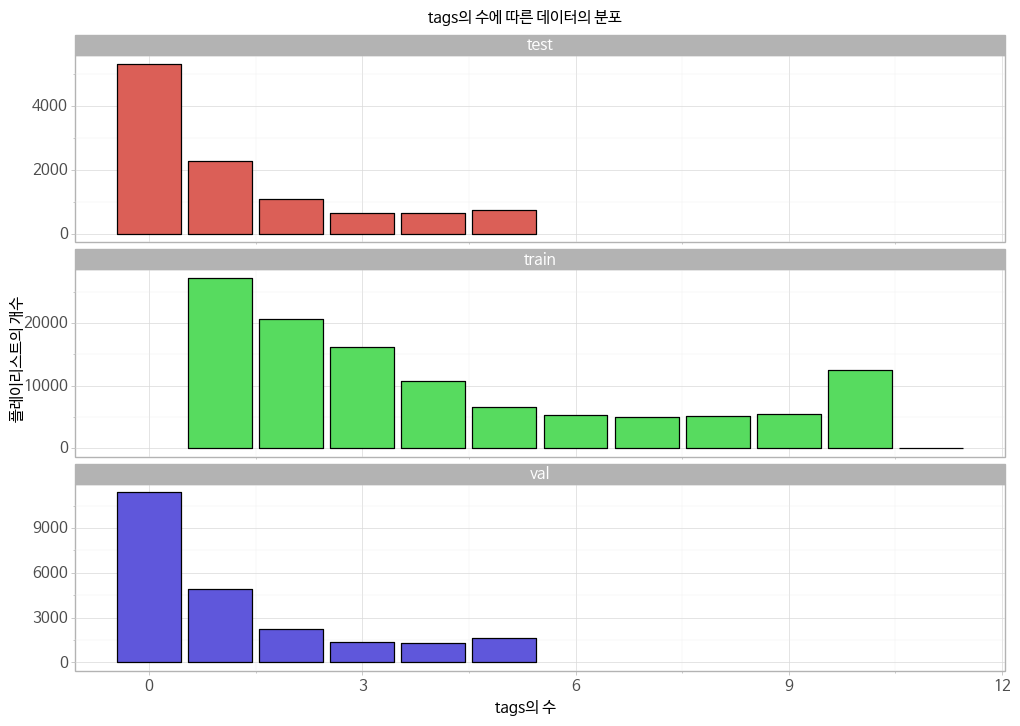

<ggplot: (121268337398)>

In [147]:
agg = total.groupby(['tags_cnt', 'type'])['tags_cnt'].agg({'count'}).reset_index().rename(columns={'count':'사람의 수'})
(ggplot(data=agg) 
    + geom_bar(aes(x='tags_cnt', y='사람의 수', group='type', fill='type'), color='black', stat='identity')
    + facet_wrap('type', nrow=3, scales = "free_y")
    #+ scale_x_discrete(limits=sorted_columns)
    + scale_color_hue(l=0.45)
    + theme_light() 
    + labs(title = 'tags의 수에 따른 데이터의 분포',
         x = 'tags의 수',
         y = '플레이리스트의 개수')
    + theme(text = element_text(fontproperties=font_name),
        #axis_text_x = element_text(angle=80),
        figure_size=(12,8),
        legend_position="none"))

tags의 경우 최소 1개, 최대 11개으로 판단됩니다. 하지만 val과 test는 6이상인 값들은 없고 대회 설명처럼 일부가 삭제된 것을 볼 수 있습니다. 추측하건데 50%으로 제거되고 일부는 0으로 매핑한 것 같습니다. 

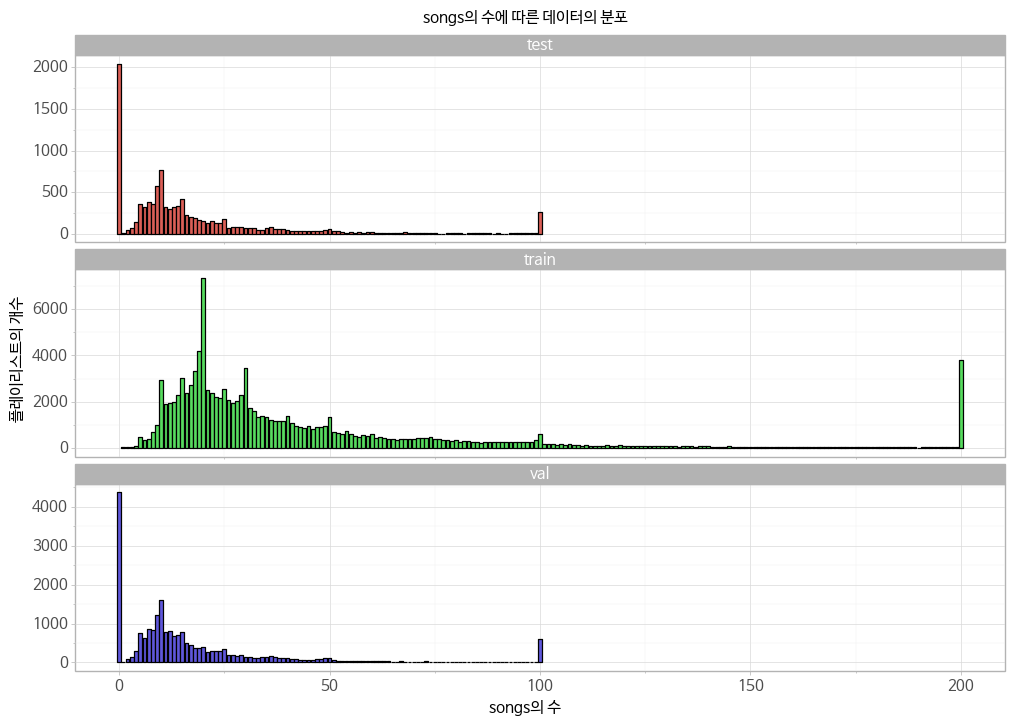

<ggplot: (-9223371915649296608)>

In [148]:
agg = total.groupby(['songs_cnt', 'type'])['songs_cnt'].agg({'count'}).reset_index().rename(columns={'count':'사람의 수'})
(ggplot(data=agg) 
    + geom_bar(aes(x='songs_cnt', y='사람의 수', group='type', fill='type'), color='black', stat='identity')
    + facet_wrap('type', nrow=3, scales = "free_y")
    #+ scale_x_discrete(limits=sorted_columns)
    + scale_color_hue(l=0.45)
    + theme_light() 
    + labs(title = 'songs의 수에 따른 데이터의 분포',
         x = 'songs의 수',
         y = '플레이리스트의 개수')
    + theme(text = element_text(fontproperties=font_name),
        #axis_text_x = element_text(angle=80),
        figure_size=(12,8),
        legend_position="none"))

songs의 경우 최소 1개, 최대 200개으로 판단됩니다. 하지만, val과 test는 100을 넘는 값들은 없습니다. tag와 마찬가지로 50%으로 제거되고 일부는 0으로 매핑한 것 같습니다. 

## DJ 플레이리스트 조건에 따른 데이터 탐색
이전에 DJ 플레이리스트 신청하기에서 본 것처럼 DJ 플레이리스트를 신청하려면 특정 조건들을 만족해야합니다. 
먼저, **동일가수/앨범이 편중되지 않았는 지?**를 확인하기 위해서 해당 항목을 확인해 보겠습니다. 그 전에 먼저 앨범에 매핑된 곡의 수부터 살펴보겠습니다. 

In [48]:
meta.head(1)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0


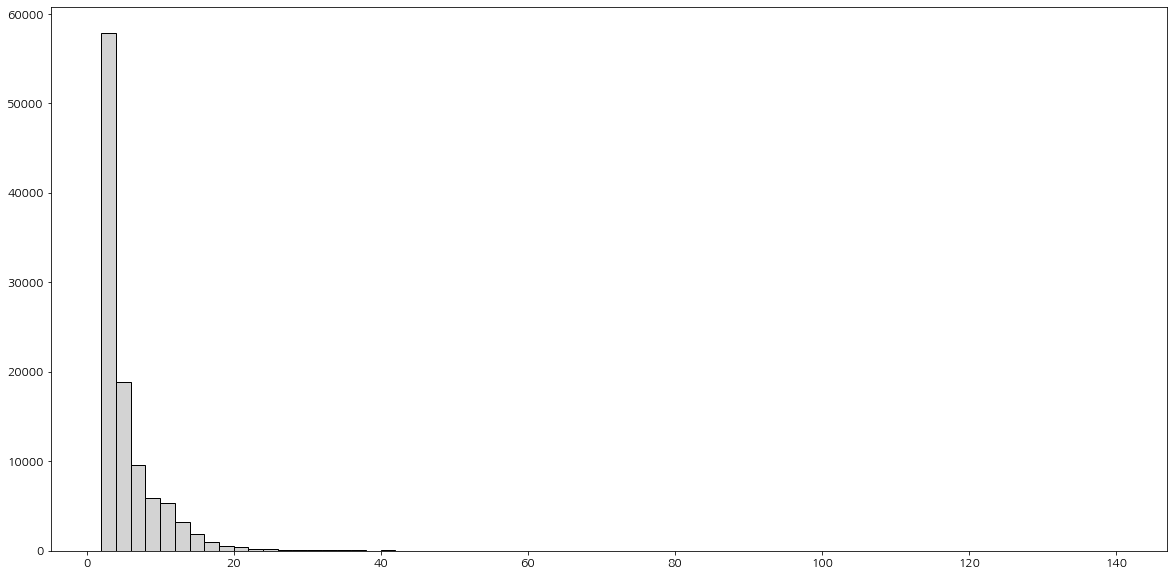

In [46]:
# 1. 앨범별 수록된 곡의 수 테이블 
album_song_cnt = pd.DataFrame(meta.groupby('album_id').id.nunique())

# 2-1. grid setting
grid_list = [i*2 for i in range(1, 71)]

# 2-2. plotting
plt.hist(album_song_cnt['id'], grid_list, color = "lightgrey", edgecolor = "black")
plt.show()

In [47]:
round(album_song_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
id,1.0,1.0,1.0,2.46,2.0,142.0,3.55


앨범 하나에 매핑된 곡의 평균적으로 2.46개이며 중앙값으로는 1의 값을 가집니다. 그리고 100개 이상의 곡이 매핑된 경우도 있는데 그러한 앨범은 아래와 같습니다. 앨범의 이름과 아티스트명을 보면 알겠지만, 다양한 아티스의 곡이 포함된 형태 또는 많은 곡을 작성한 사람들(모짜르트, 김광성)인 것을 확인할 수 있습니다.

In [63]:
album_song_cnt = album_song_cnt.reset_index()
for i in album_song_cnt[album_song_cnt['id'] > 100]['album_id'].values: 
    print(meta[meta['album_id'] == album_song_cnt[album_song_cnt['album_id'] == i]['album_id'].values[0]][['album_name', 'artist_name_basket']].values[0])

['Satie : Oeuvres Pour Piano' list(['Aldo Ciccolini'])]
['Mozart : Piano Sonatas, Violin Sonatas, Piano Duets & Piano Works'
 list(['Mozart 250 Anniversary'])]
['기독교인이 가장 좋아하는 묵상음악 101' list(['Various Artists'])]
['김광석 `나의 노래` Box Set' list(['김광석'])]
['동요나라 동요천국 180곡' list(['동요천국'])]
['새콤 달콤 유아동요 베스트 300' list(['Various Artists'])]
['Tchaikovsky : The Complete Solo Piano Works' list(['Valentina Lisitsa'])]


In [57]:
meta[meta['album_id'] == 2136746].head(2)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
9422,[GN0801],20120709,김광석 `나의 노래` Box Set,2136746,[2960],이등병의 편지,[GN0800],[김광석],9422
11464,[GN0801],20120709,김광석 `나의 노래` Box Set,2136746,[2960],그녀가 처음 울던 날,[GN0800],[김광석],11464


이러한 사실을 인지하고 동일 앨범의 수록곡과 동일 가수의 수록곡이 플레이리스트에 몇 개가 있는지 확인해보겠습니다. 

In [114]:
album_list = meta['album_id'].values
artist_list = meta['artist_name_basket'].values

# 동일 앨범의 수록곡에 대한 개수 
e = Counter()

# 동일 가수에 대한 개수(단, various Artist는 제외)
f = Counter()

# 플레이 리스트별 동일 앨범, 가수의 최대수
album_cnt = []; singer_cnt = []; 
for i in notebook.tqdm(train['songs']):
    c = Counter()
    d = Counter()
    for j in i: 
        # index와 곡의 번호가 동일
        c.update({album_list[j]: 1})
        if artist_list[j][0] == 'Various Artists': continue
        d.update({artist_list[j][0]: 1})
    
    album_cnt.append(max(c.values()))
    
    # 모든 앨범의 곡이 Various Artists인 경우 
    try: singer_cnt.append(max(d.values())) 
    except: singer_cnt.append(1)
    
    for k in c.values(): 
        e.update({k: 1})
        
    for k in d.values(): 
        f.update({k: 1})

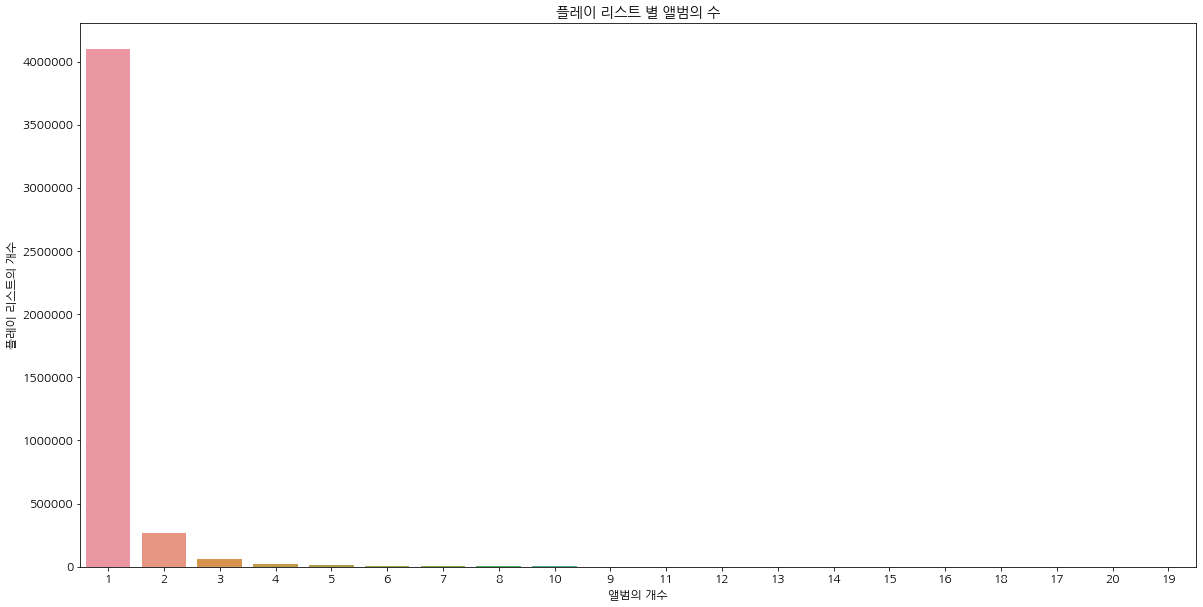

In [64]:
# 1. 동일 앨범의 수록 수에 대한 데이터프레임을 완성 
album_df = pd.DataFrame(data = np.array([list(e.keys()), list(e.values())]).T, columns=['동일 앨범의 수록 수', '전체 사용자의 갯수'])
album_df = album_df.sort_values(by='전체 사용자의 갯수', ascending=False).reset_index(drop=True)

# 2. 시각화 
album_plot = sns.barplot(x = '동일 앨범의 수록 수', y = '전체 사용자의 갯수', data = album_df.head(20), order = album_df['동일 앨범의 수록 수'].head(20))
album_plot.set_title('플레이 리스트 별 앨범의 수')
album_plot.set_xlabel('앨범의 개수')
album_plot.set_ylabel('플레이 리스트의 개수')
plt.xticks(rotation = 0)
plt.show()

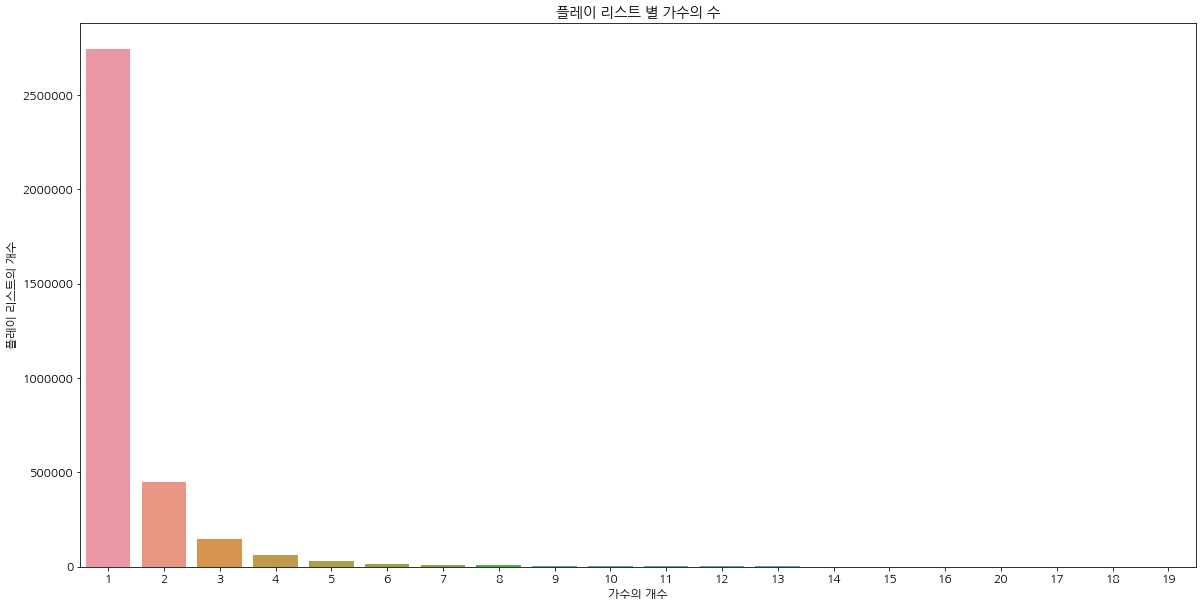

In [65]:
# 1. 동일 가수의 수록 수에 대한 데이터프레임을 완성 
singer_df = pd.DataFrame(data = np.array([list(f.keys()), list(f.values())]).T, columns=['동일 가수의 수록 수', '전체 사용자의 갯수'])
singer_df = singer_df.sort_values(by='전체 사용자의 갯수', ascending=False).reset_index(drop=True)

# 2. 시각화 
singer_df_plot = sns.barplot(x = '동일 가수의 수록 수', y = '전체 사용자의 갯수', data = singer_df.head(20), order = singer_df['동일 가수의 수록 수'].head(20))
singer_df_plot.set_title('플레이 리스트 별 가수의 수')
singer_df_plot.set_xlabel('가수의 개수')
singer_df_plot.set_ylabel('플레이 리스트의 개수')
plt.xticks(rotation = 0)
plt.show()

위의 두그래프를 보면 플레이 리스트는 대부분이 앨범이 3개 이하이고 가수는 5명 이하입니다. 하지만 그렇지 않은 플레이 리스트도 많습니다. 해당 플레이 리스트에서 동일 가수와 동일 앨범이 가장 많은 플레이 리스트를 살펴보면, 아래와 같습니다.  

In [118]:
train.loc[album_cnt.index(max(album_cnt))]

tags                                                        [클래식]
id                                                           2283
plylst_title                                            사티의 몽환의 밤
songs           [657814, 571431, 447673, 256725, 304836, 58868...
like_cnt                                                       10
updt_date                                 2015-04-08 23:23:18.000
type                                                        train
Name: 15683, dtype: object

In [126]:
c = Counter()
for song in train.loc[album_cnt.index(max(album_cnt))]['songs']: c.update({meta[meta['id'] == song]['album_name'].values[0]: 1})
print(c)

Counter({'Satie : Oeuvres Pour Piano': 138, 'Theodorakis : The Guitarist': 2, 'Chill With Satie': 2, 'Humoresque': 1, 'Eternal Satie': 1})


In [120]:
train.loc[singer_cnt.index(max(singer_cnt))]

tags                                                        [CCM]
id                                                          74990
plylst_title                                              일천번제 전곡
songs           [370263, 288679, 572345, 514251, 683792, 45717...
like_cnt                                                       14
updt_date                                 2015-10-28 10:19:11.000
type                                                        train
Name: 5713, dtype: object

In [135]:
c = Counter()
for song in train.loc[singer_cnt.index(max(singer_cnt))]['songs']: 
    for singer in meta[meta['id'] == song]['artist_name_basket'].values[0]:
        c.update({singer: 1})
print(c)

Counter({'일천번제': 200})


특징을 살펴보면 클랙식과 같이 동일 앨범내에 수록곡이 많거나 전곡 모음처럼 특정 가수의 곡만을 담은 플레이리스트임을 알 수 있습니다. 이러한 사실을 바탕으로 특정 가수 혹은 앨범의 곡이 많이 담긴 플레이리스트를 찾는 방법도 좋은 추천 방법이 될 것 같습니다. 

## plylst_title의 정보를 활용해서 추천할 수 있는 경우
멜론 DJ신청하기의 설명을 보면, plylst_title는 제목은 선곡의 테마 및 장르를 대표할 수 있는 형태여야 합니다. 또한, 대회 데이터의 19%가 제목이 있기에 제목을 활용해서 잘 추천하는 것이 중요합니다. 아래는 여행이라는 태그를 통해서 검색한 화면인데, 제목과 태그간의 연관성 있는 것을 확인할 수 있습니다. 

![](https://drive.google.com/uc?export=view&id=1QRLoUk1C5-PE1H98G6eWl5fIQ6j6pKsl)

In [164]:
for i in train['plylst_title'].unique()[0:10]: print(i)

여행같은 음악
요즘 너 말야
편하게, 잔잔하게 들을 수 있는 곡.-
크리스마스 분위기에 흠뻑 취하고 싶을때
추억의 노래 ㅋ
2017 Pop Trend
짝사랑..고백..사랑..이별..슬픔.. 감성을 자극하는곡들!
멍청이.. 내맘도 몰라.
DANCING IN THE MOON-LIGHT .01
[록/메탈] Written by 이일우


또한, 90년대 신나는곡이나 쇼미더머니8노래모음, 헤이즈 모음, 조용필처럼 몇개의 경우는 플레이 리스트의 제목만 보고 쉽게 수록 곡의 정보를 알 수 있습니다. 

In [165]:
for i in train[train['plylst_title'] == '헤이즈 모음']['songs'].values[0]: print(meta[meta['id'] == i][['song_name', 'artist_name_basket']].values[0])

['품 스윗 품 (Feat. Monokim)' list(['헤이즈 (Heize)'])]
['돌아오지마 (Feat. 용준형 Of 비스트)' list(['헤이즈 (Heize)'])]
['Shut Up & Groove (Feat. DEAN)' list(['헤이즈 (Heize)'])]
['And July (Feat. DEAN, DJ Friz)' list(['헤이즈 (Heize)'])]
['Underwater' list(['헤이즈 (Heize)'])]
['저 별' list(['헤이즈 (Heize)'])]
['널 너무 모르고' list(['헤이즈 (Heize)'])]
['먹구름 (Feat. nafla)' list(['헤이즈 (Heize)'])]
['비도 오고 그래서 (Feat. 신용재)' list(['헤이즈 (Heize)'])]
['내가 더 나빠' list(['헤이즈 (Heize)'])]


## 메타 데이터의 날짜 잘못된 것 수정
Disscussion [DB metadata에 문제점이 있는 것 같습니다!](https://arena.kakao.com/forum/topics/201)에 따르면 몇몇 곡들의 날짜가 잘 맞지 않는 것을 볼 수 있습니다. 

In [166]:
# 곡 아이디(id)와 대분류 장르코드 리스트(date_gn_gnr_basket) 추출
playlist_id_date_map = total.loc[:, ['songs','updt_date']]

# unnest date_gn_gnr_basket
playlist_id_map_unnest = np.dstack(
    (
        np.concatenate(playlist_id_date_map.songs.values),
        np.repeat(playlist_id_date_map.updt_date.values, list(map(len, playlist_id_date_map.songs))), 
    )
)

# unnested 데이터프레임 생성 : playlist_id_map
playlist_id_date_map = pd.DataFrame(data = playlist_id_map_unnest[0], columns = playlist_id_date_map.columns)

# unnest 객체 제거
del playlist_id_map_unnest

# meta는 데이터 형태
meta_song = meta[['id', 'issue_date']].rename(columns ={'id' : 'songs'})

playlist_id_date_map['updt_date'] = pd.to_datetime(playlist_id_date_map['updt_date']).apply(lambda x: x.strftime("%Y%m%d"))
playlist_id_date_map['updt_date'] = playlist_id_date_map['updt_date'].astype(int)
playlist_id_date_agg = playlist_id_date_map.groupby(['songs'])['updt_date'].agg({'max'}).reset_index().rename(columns = {'max':'updt_date'})
playlist_id_date_agg['songs'] = playlist_id_date_agg['songs'].astype(int)
playlist_id_date_agg = playlist_id_date_agg.merge(meta_song, how='left', on='songs')

In [172]:
playlist_id_date_agg.loc[playlist_id_date_agg['updt_date'] < playlist_id_date_agg['issue_date']].head()

,songs,updt_date,issue_date
140,153,20170705,20170804
945,1035,20100119,20181121
2269,2507,20061011,20061017
2765,3047,20160121,20180525
4460,4902,20140607,20160826


In [171]:
playlist_id_date_agg.loc[playlist_id_date_agg['updt_date'] < playlist_id_date_agg['issue_date']].shape

(724, 3)

724개의 곡들이 updt_date보다 이후에 발매되었다고 나옵니다. 이러한 곡들은 Notebook에서 언급된 [곡의 발매 일자가 플레이리스트의 최종 수정일보다 늦은 경우](https://arena.kakao.com/forum/topics/217)의 방법을 사용하기 어려우니 다음과 같은 수정이 필요합니다. 

In [174]:
# 해당 issue_date를 updt_date로 수정 
playlist_id_date_agg.loc[playlist_id_date_agg['updt_date'] < playlist_id_date_agg['issue_date'], 'issue_date'] = playlist_id_date_agg.loc[playlist_id_date_agg['updt_date'] < playlist_id_date_agg['issue_date'], 'updt_date']
playlist_id_date_agg.columns = ['id', 'updt_date', 'updated_issue_date']

또한, issue_date에서 신기한 날짜들이 있습니다. 예를들어, 아래의 0이라든지 20100931처럼 없는 날짜라든지 전처리가 필요해보입니다. 

In [193]:
print(playlist_id_date_agg['updated_issue_date'].min(), "\n")
print(playlist_id_date_agg[playlist_id_date_agg['updated_issue_date'] == 20010931])

0 

            id  updt_date  updated_issue_date
154086  168071   20180427            20010931
